In [1]:
###autocall backtest

#phoenix, phoenix memory athena brc 
#params autocall: trigg barrier, barrier active or not, trigg coupon, coupon barrier, coupon, coupon barrier active or not
#params product :  maturity, frquence, start date, 


In [1]:
import pandas as pd
import numpy as np
import pip
pip.main(["install", "openpyxl"])
from IPython.display import display
import time

import openpyxl
from pandas.tseries.offsets import DateOffset




Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


## We create a class "Autocall" containing all the data from the file
* `__init__` : loads the data of the stocks
* `data_acs` : loads the data of the Autocall product
    * for inactive coupon/trigger barriers, we replace their value by 999.
* `data_stocks` : computes the stocks returns based on the type of the basket
    * method : we want to make a unique dataframe indexed by dates **that all stocks have in common**. Sometimes, hollidays are not the same for US or EU stocks, so it's important to be careful.
    * we split the df into unique stock dfs, we rename the columns dates and we merge all the dataframes.
    * the result is a df indexed by common dates, which columns are stocks values.
    * finally, we compute the returns based on the type : worst-of, equally-weighted and best-of

In [2]:
class autocall():
    def __init__(self):
        self.data_acs()
        self.stocks_data = self.data_stock()
    def data_acs(self):
        df=pd.read_excel("Autocall.xlsm",skiprows=10,usecols=range(6,12)).dropna(axis=0, how="all")
        sheet = openpyxl.load_workbook("Autocall.xlsm")["Control"]
        self.trigg_bar =df[df.columns.values[0]].to_numpy() -998*(df[df.columns.values[2]].to_numpy()-1)
        self.trigg_coupon=df[df.columns.values[1]].to_numpy()
        self.coupon_bar=df[df.columns.values[4]].to_numpy()*0-998*(df[df.columns.values[3]].to_numpy()-1)
        self.coupon=df[df.columns.values[5]].to_numpy()
        self.coupon_memory = sheet["c32"].value
        self.pdi_strike,self.pdi_barrier,self.pdi_leverage = sheet["c28"].value,sheet["c29"].value,sheet["c30"].value
        self.T,self.basket_type  = int(int(sheet["C25"].value[:-1])/12),sheet["c23"].value
        self.freq = int(12*self.T/len(self.coupon))
                
    def data_stock(self):

        data_stocks_old = pd.read_excel("Autocall.xlsm", skiprows = 3,  sheet_name = 1) #usecols = range(1,9),
        data_stocks_old = data_stocks_old.dropna(axis = "columns", how="all")

        L=[data_stocks_old[data_stocks_old.columns.values[2*i:2*(i+1)]] for i in range(int(len(data_stocks_old.columns)/2))]
        
        for df in L : df.columns.values[0]="Dates"
        data_stocks=L[0]
        
        for df in L[1:] :  data_stocks=data_stocks.merge(df,how = "inner",on="Dates")
        
        data_stocks = data_stocks.set_index("Dates")
        self.start_date = data_stocks.index[0]

        if len(data_stocks.columns)== 1 : #si un seul stock
            return data_stocks.apply(lambda x: x.div(x.iloc[0])) 
        else:
            if self.basket_type == "EQW":
                return pd.Series.to_frame(data_stocks.apply(lambda x: x.div(x.iloc[0])).sum(axis=1) / len(data_stocks.columns))
            elif self.basket_type == "WOF":
                return pd.Series.to_frame(data_stocks.apply(lambda x: x.div(x.iloc[0])).min(axis=1))
            elif self.basket_type == "BOF":
                return pd.Series.to_frame(data_stocks.apply(lambda x: x.div(x.iloc[0])).max(axis=1))



## We create a class backtest : from the Autocall dates and data, we run the backtest
`singlebacktest(self,date)` : computes the backtest starting from **date**
* from **date**, we get all the dates every  **freq** months until maturity. We offset the last date by **freq** months and we take the closest that is in our stocks dataframe.
* if the last period is inferior to the frequence, the backtest is not feasible : it means that the matuirty is above our maximum possible backtest date (ultimately today): we return and absurd value
#### Very important : computations of the coupons and stopping time
* the stopping time **$\tau$** corresponds to the **first** autocall date. However, if not autocalled, it returns **0** 
    * to counter this, we check if the basket at time $\tau$ is above the barrier.
        * if it is not the case, we set trigger coupon to 0 and put $\tau$ to the **last barrier** : the PDI only activates if $S_{\tau}\leq B_{\tau}$, so it works if we set $\tau$ to the maturity (since $\tau=0$ at the begining, this condition is filled.)
* the coupon : this is more complex, as we have the case **with memory**, and **no memory**:
    * no memory : we take the boolean list of when $S_t>B_{coupon,t}$ for $t \in [0,\tau]$. We then multiply it by the coupon list for $t \in [0,\tau]$.
    * with memory (complex): when a coupon barrier is breached, the client receives all the unpayed previous coupons. That means, if the last breach of the barrier occurs at $t=t^*$,the coupon paid will be $\sum_{t=1}^{t^{*}}c_t$.
        * take the **boolean** list of if $S_t>B_{coupon,t}$ for $t \in [0,\tau]$
        * take the last occurrence of when it breaches the coupon barrier : we reverse the list, take the argmax $i$. 
        * /!\ the real index in the coupon barriers list will be $\tau-i$ (as it was reversed)
        * we then sum the coupon list until this index.
        * we then sum the coupon list until this index.

`backtest_all(self)` : we run the backtest for all possible dates and stop when we get an error value (ie when we went past the feasible strike date)
 

In [3]:
class backtest(autocall):
    def __init__(self):
        autocall.__init__(self)
    def singlebacktest(self,date):
        #################### take the good data dates ###########################
        stocks = self.stocks_data.loc[date:]
        index=[stocks.index[0]]
        for i in range(len(self.trigg_bar)): index.append(stocks.index[stocks.index.get_loc(index[-1]+pd.DateOffset(months= self.freq),method="nearest")])
        stocks = stocks.loc[index[1:]]
        
        
        if (index[-1] - index[-2]).days <self.freq*20 : return -203 # la derniere periode est trop courte
        tau=(stocks[0]>=self.trigg_bar).argmax() #peut retourner 0 si tout le temps inférieur

        trigg_coupon = float(self.trigg_coupon[tau]) if (stocks.iloc[tau].values>=self.trigg_bar[tau]) else 0 #trigg coupon si recall sinon 0 et dans pdi eventuel
                                                                                                                                                            
        if stocks.iloc[tau].values<self.trigg_bar[tau]: tau = len(self.trigg_bar)-1 #on est en dessous de la trigger
        pdi = float(-1*(stocks.iloc[tau].values<self.trigg_bar[tau])*(stocks.iloc[-1]<= self.pdi_barrier)*(self.pdi_strike-stocks.iloc[-1])*self.pdi_leverage)
        
        if self.coupon_memory == False:
            coupon=((stocks[0]>=self.coupon_bar)[:tau+1]*self.coupon[:tau+1]).sum() 
        else: 
            coupon = (self.coupon[:(tau+1)-(stocks[0]>=self.coupon_bar)[:tau+1].to_numpy()[::-1].argmax()]).sum()#*(stocks[0]>self.coupon_bar)[:tau+1]).sum()
        return  trigg_coupon + coupon + pdi +1 
        
    def backtest_all(self) :
        index = min(self.stocks_data.index,key=lambda x: abs(x-(self.stocks_data.index[0] + pd.DateOffset(months=self.T*12))))
        stock= self.stocks_data.loc[:index]
        L=[]
        
        for date in stock.index : 
            if self.singlebacktest(date) >-203:
                L.append([date,self.singlebacktest(date)])  
            else:
                break 
 ############################## Data frame with dates and results ########################################       
        Dates = [i[0] for i in L]
        Results = [i[1] for i in L]
        backtest=pd.DataFrame({"Dates":Dates, "Results": Results}).set_index("Dates")

        return backtest
        
        


temps du backtest : 48.92980432510376


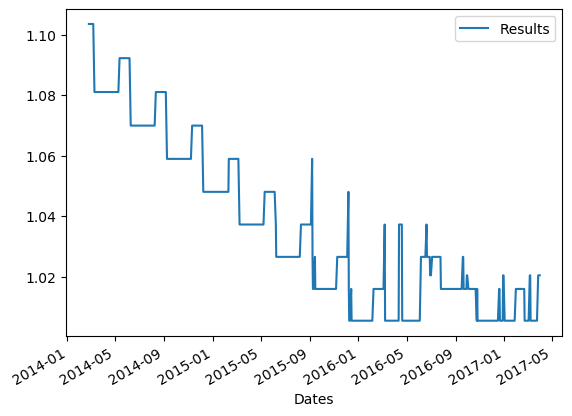

In [4]:
test_autocall=backtest()
start=time.time()
backtest=test_autocall.backtest_all()
end=time.time()
print("temps du backtest :", end-start)


import matplotlib.pyplot as plt
backtest.plot()
plt.show()